### __Tabular Model__

- スペクトログラムを作成

    https://mne.tools/stable/auto_tutorials/clinical/60_sleep.html#feature-engineering

In [1]:
from utils import *

In [2]:
# データの読み込み
train_epochs = load_epoch("train")
test_epochs = load_epoch("test")

In [3]:
def epoch_to_df(epoch):
    df = epoch.to_data_frame(verbose=False)
    new_meas_date = epoch.info["meas_date"].replace(tzinfo=None) + datetime.timedelta(seconds=epoch.info["temp"]["truncate_start_point"])
    df["meas_time"] = pd.date_range(start=new_meas_date, periods=len(df), freq=pd.Timedelta(1 / 100, unit="s"))
    df["night"] = epoch.info["temp"]["night"]
    df["age"] = epoch.info["temp"]["age"]
    df["sex"] = epoch.info["temp"]["sex"]
    return df

In [4]:
def epoch_to_sub_df(epoch_df, id, is_train):
    # 使用カラム
    cols = ["id", "meas_time", "Resp oro-nasal", "EMG submental", "Temp rectal", "Event marker", "night", "age", "sex"]
    
    # 訓練データにはアノテーション追加
    if is_train:
        cols.append("condition")

    label_df = epoch_df.loc[epoch_df.groupby("epoch")["time"].idxmin()].reset_index(drop=True)
    label_df["id"] = id

    return label_df[cols]

In [5]:
def power_band(epochs):
    channels = ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"]
    spectrum = epochs.compute_psd(picks=channels, verbose=False)
    psds, freqs = spectrum.get_data(return_freqs=True)
    psds /= np.sum(psds, axis=-1, keepdims=True) # 正規化

    X = []
    for i in range(len(channels)):
        for j in range(int(freqs[-1])):
            psds_band_mean = psds[:, i, (freqs >= j) & (freqs < j+1)].mean(axis=-1)
            X.append(psds_band_mean.reshape(len(psds), -1))
    return np.concatenate(X, axis=1)

In [6]:
train_df = []
for epoch in tqdm(train_epochs):
    # 波形をdataframe化
    epoch_df = epoch_to_df(epoch)
    # submit形式のデータフレーム生成
    sub_df = epoch_to_sub_df(epoch_df, epoch.info["temp"]["id"], is_train=True)
    
    # パワースペクトル密度計算
    feature_df = pd.DataFrame(power_band(epoch))
    
    _df = pd.concat([sub_df, feature_df], axis=1)
    # 必要ないラベルがある場合は除外する
    _df = _df[~_df["condition"].isin(["Sleep stage ?", "Movement time"])]
    
    train_df.append(_df)

train_df = pd.concat(train_df).reset_index(drop=True)

  0%|          | 0/108 [00:00<?, ?it/s]

In [7]:
# ラベルIDに変換
train_df["condition"] = train_df["condition"].map(LABEL2ID)
train_df

,id,meas_time,Resp oro-nasal,EMG submental,Temp rectal,Event marker,night,age,sex,condition,...,140,141,142,143,144,145,146,147,148,149
0,3c1c5cf,1989-11-13 21:35:00,3.100000e+07,3.314,1.427192e+07,9.530000e+08,1,90,male,4,...,0.000419,0.000326,0.000364,0.000330,0.000447,0.000443,0.000409,0.000427,0.000446,0.000371
1,3c1c5cf,1989-11-13 21:35:30,7.000000e+06,3.294,1.427329e+07,9.750000e+08,1,90,male,4,...,0.000776,0.000492,0.000475,0.000497,0.000497,0.000484,0.000436,0.000506,0.000538,0.000477
2,3c1c5cf,1989-11-13 21:36:00,-4.000000e+06,3.272,1.427649e+07,9.420000e+08,1,90,male,4,...,0.000382,0.000403,0.000524,0.000441,0.000508,0.000566,0.000429,0.000511,0.000463,0.000440
3,3c1c5cf,1989-11-13 21:36:30,7.000000e+06,3.316,1.426780e+07,9.630000e+08,1,90,male,4,...,0.000160,0.000158,0.000138,0.000108,0.000122,0.000173,0.000157,0.000136,0.000162,0.000139
4,3c1c5cf,1989-11-13 21:37:00,8.000000e+06,3.218,1.428519e+07,9.710000e+08,1,90,male,4,...,0.000444,0.000346,0.000300,0.000296,0.000410,0.000392,0.000292,0.000343,0.000409,0.000476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161605,5edb9d9,1990-03-14 08:17:30,-7.200000e+08,3.934,1.418677e+07,1.049000e+09,2,73,male,2,...,0.000018,0.000029,0.000029,0.000017,0.000016,0.000015,0.000012,0.000009,0.000013,0.000013
161606,5edb9d9,1990-03-14 08:18:00,-1.366000e+09,3.800,1.421103e+07,1.076000e+09,2,73,male,2,...,0.000021,0.000032,0.000022,0.000027,0.000018,0.000021,0.000013,0.000010,0.000010,0.000012
161607,5edb9d9,1990-03-14 08:18:30,1.808000e+09,2.592,1.421149e+07,1.051000e+09,2,73,male,1,...,0.000047,0.000050,0.000065,0.000048,0.000042,0.000052,0.000033,0.000030,0.000033,0.000017
161608,5edb9d9,1990-03-14 08:19:00,-1.367000e+09,2.238,1.421424e+07,1.028000e+09,2,73,male,1,...,0.000036,0.000032,0.000040,0.000031,0.000032,0.000043,0.000030,0.000029,0.000024,0.000028


In [8]:
test_df = []
for epoch in tqdm(test_epochs):
    # 波形をdataframe化
    epoch_df = epoch_to_df(epoch)
    # submit形式のデータフレーム生成
    sub_df = epoch_to_sub_df(epoch_df, epoch.info["temp"]["id"], is_train=False)

    # パワースペクトル密度計算
    feature_df = pd.DataFrame(power_band(epoch))
    _df = pd.concat([sub_df, feature_df], axis=1)
    test_df.append(pd.concat([sub_df, feature_df], axis=1))
test_df = pd.concat(test_df)

  0%|          | 0/45 [00:00<?, ?it/s]

In [12]:
sex_map = {"male": 0, "female": 1}
train_df["sex"] = train_df["sex"].map(sex_map)
test_df["sex"] = test_df["sex"].map(sex_map)

### __学習__

- idでGroupKFold

    - ただしscikit-learnの`GroupKFold`は`random_state`が設定できないので`KFold`で実装

    - train: 80％

    - valid: 20%

- モデル: ランダムフォレスト

In [9]:
def custom_accuracy(y_pred, data):
    y_true = data.get_label()
    y_pred = y_pred.reshape(5, -1).argmax(axis=0)
    accuracy = accuracy_score(y_true, y_pred)
    return 'accuracy', accuracy, True

In [13]:
X = train_df.drop(columns=["id", "meas_time", "condition"])
y = train_df["condition"]
X_test = test_df.drop(columns=["id", "meas_time"])

SEED = 42
N_SPLITS = 10

params = {
    "boosting": "gbdt", # "gbdt"
    "objective": "multiclass", # 2値分類
    "seed": SEED,
    "num_leaves": 63,
    "learning_rate": 0.01,  # 学習率
    "feature_fraction": 0.8,
    "bagging_freq": 1,
    "bagging_fraction": 0.8,
    'num_class': 5, # クラス数
}

cv_scores, results, models = [], [], []
test_prediction =  pd.DataFrame()
kf = KFold(n_splits=N_SPLITS, random_state=SEED, shuffle=True)
unique_ids = train_df["id"].unique()
for fold, (train_id_index, valid_id_index) in tqdm(enumerate(kf.split(unique_ids)), total=N_SPLITS):
    train_index =  train_df["id"].isin(unique_ids[train_id_index])
    valid_index =  train_df["id"].isin(unique_ids[valid_id_index])

    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    result = {}
    model = lgb.train(
        params=params,
        train_set=lgb_train, # 学習データ
        valid_sets=[lgb_train, lgb_valid], # 検証データ
        valid_names=['train', 'valid'], # 学習経過で表示する名称
        num_boost_round=1000, # イテレーションの回数
        feval=custom_accuracy,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=False), # アーリーストッピング
            lgb.callback.record_evaluation(result), # ログの記録
            lgb.log_evaluation(0), # ログの表示
        ],
    )
    results.append(result)
    models.append(model)        

    score = result["valid"]["accuracy"][-1]
    cv_scores.append(score)
    print(f'Fold: {fold+1}  Accuracy: {score}')

    # 推論
    test_prediction[str(fold)] = model.predict(X_test).argmax(axis=1)
print(f"CV Score {np.mean(cv_scores)}")

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.287906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39303
[LightGBM] [Info] Number of data points in the train set: 144761, number of used features: 157
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -2.958582
[LightGBM] [Info] Start training from score -1.238058
[LightGBM] [Info] Start training from score -2.451117
[LightGBM] [Info] Start training from score -2.191185
[LightGBM] [Info] Start training from score -0.776139
Fold: 1  Accuracy: 0.858982728945338
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076381 seconds.
You can set `force_row_wise=true` to remove the ove

### __提出ファイルの作成__

In [14]:
sample_submission_df = pd.read_csv(SUBMISSION_DIR / "sample_submission.csv", parse_dates=[1])
sample_submission_df

,id,meas_time,condition
0,53c1555,1989-11-20 23:19:30,Sleep stage W
1,53c1555,1989-11-20 23:20:00,Sleep stage W
2,53c1555,1989-11-20 23:20:30,Sleep stage W
3,53c1555,1989-11-20 23:21:00,Sleep stage W
4,53c1555,1989-11-20 23:21:30,Sleep stage W
...,...,...,...
52291,9b444bb,1989-04-12 07:32:30,Sleep stage W
52292,9b444bb,1989-04-12 07:33:00,Sleep stage W
52293,9b444bb,1989-04-12 07:33:30,Sleep stage W
52294,9b444bb,1989-04-12 07:34:00,Sleep stage W


In [15]:
sample_submission_df["condition"] = test_prediction.mode(axis=1).iloc[:, 0].astype(int) # アンサンブル
sample_submission_df["condition"] = sample_submission_df["condition"].map(ID2LABEL)
sample_submission_df.to_csv(SUBMISSION_DIR / "exp05.csv", index=False)
sample_submission_df

,id,meas_time,condition
0,53c1555,1989-11-20 23:19:30,Sleep stage W
1,53c1555,1989-11-20 23:20:00,Sleep stage W
2,53c1555,1989-11-20 23:20:30,Sleep stage W
3,53c1555,1989-11-20 23:21:00,Sleep stage W
4,53c1555,1989-11-20 23:21:30,Sleep stage W
...,...,...,...
52291,9b444bb,1989-04-12 07:32:30,Sleep stage W
52292,9b444bb,1989-04-12 07:33:00,Sleep stage W
52293,9b444bb,1989-04-12 07:33:30,Sleep stage W
52294,9b444bb,1989-04-12 07:34:00,Sleep stage W


In [16]:
sample_submission_df["condition"].value_counts()

Sleep stage 2      21413
Sleep stage W      16449
Sleep stage R       6644
Sleep stage 1       4412
Sleep stage 3/4     3378
Name: condition, dtype: int64

### __学習曲線__

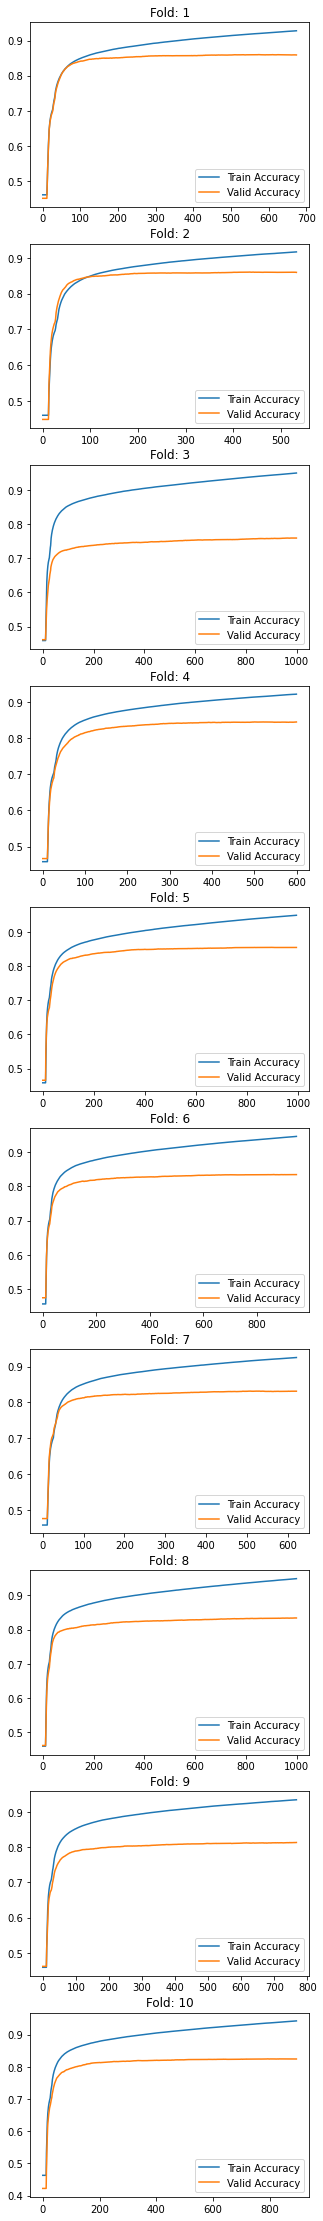

In [17]:
# fold毎に学習曲線を表示
plt.figure(figsize=(5, N_SPLITS*4))
for fold in range(N_SPLITS):
    plt.subplot(N_SPLITS, 1, fold+1)
    plt.plot(results[fold]['train']["accuracy"], label=f"Train Accuracy")
    plt.plot(results[fold]['valid']["accuracy"], label=f"Valid Accuracy")
    plt.title(f'Fold: {fold+1}')
    plt.legend()
plt.show()

### __特徴量の重要度__

In [38]:
importance = pd.DataFrame(np.mean([models[i].feature_importance(importance_type='gain') for i in range(N_SPLITS)], axis=0))
importance.index = ["Resp oro-nasal", "EMG submental", "Temp rectal", "Event marker", "night", "age", "sex"] + [f"{channel}_{str(i).zfill(2)}-{str(i+1).zfill(2)}" for channel in ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"] for i in range(50)]
importance.columns = ['importance']
importance = importance.sort_values('importance', ascending=False)
importance /= importance["importance"].sum()
importance

,importance
EEG Pz-Oz_46-47,0.072590
EMG submental,0.052663
EEG Pz-Oz_45-46,0.051798
EEG Pz-Oz_44-45,0.048291
EEG Pz-Oz_02-03,0.037501
...,...
EOG horizontal_30-31,0.000496
EOG horizontal_23-24,0.000441
EOG horizontal_25-26,0.000436
EOG horizontal_22-23,0.000405


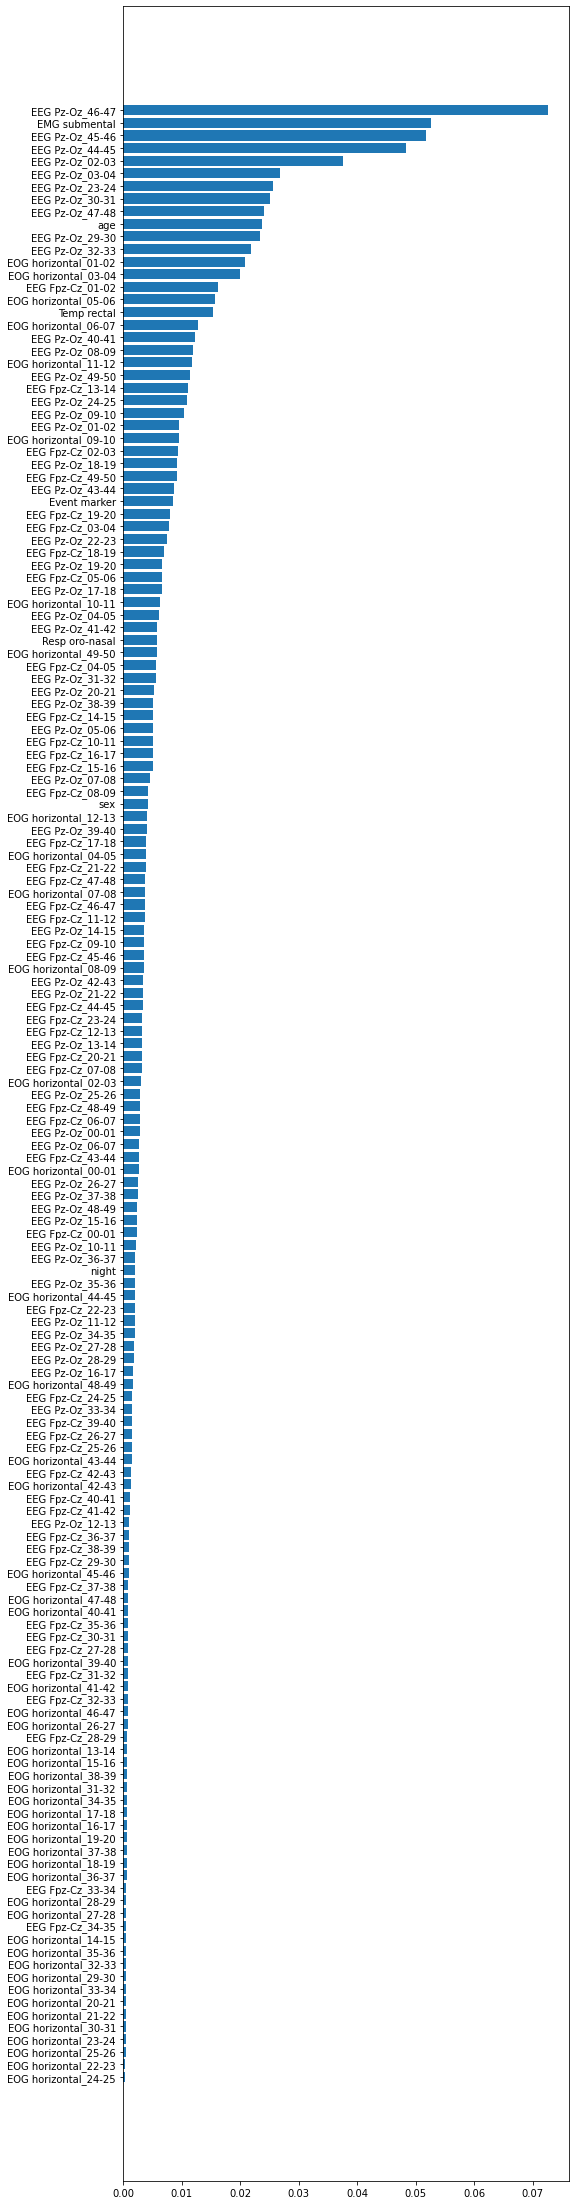

In [39]:
# 特徴量の重要度を可視化
plt.figure(figsize=(8, 40))
plt.barh(importance.index[::-1], importance.importance[::-1])
plt.savefig(DATA_DIR / "importance_plot/exp05.jpg", dpi=200)
plt.show()

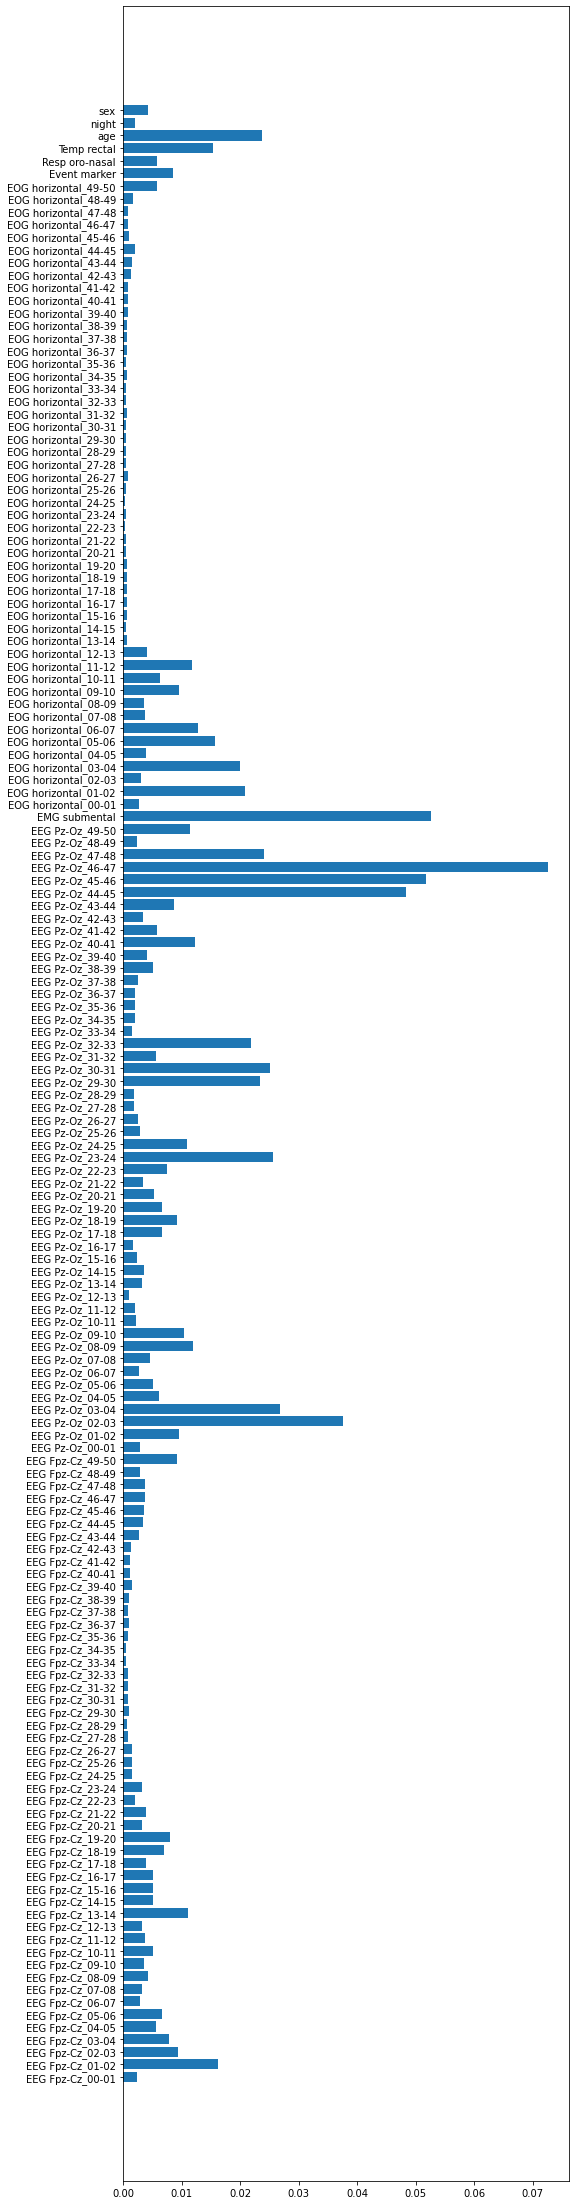

In [43]:
# indexでソートして表示
sorted_importance = importance.sort_index()

plt.figure(figsize=(8, 40))
plt.barh(sorted_importance.index, sorted_importance.importance)
plt.savefig(DATA_DIR / "importance_plot/exp05_sort_index.jpg", dpi=200)
plt.show()